
Для работы была исползована библиотека numba. Размерность  16х16.

In [7]:
import time

import matplotlib.pyplot as plt
import numpy as np
from numba import cuda, int32
from tabulate import tabulate


TPB = 16
ITER_COUNT = 8
EPS = 10e-5

In [8]:
@cuda.jit
def gpu_vec_sum(vec, res):
    """
    Calculate the sum of vec elements and save it to res
    """
    shared_buf = cuda.shared.array(TPB, dtype=int32)

    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    idx = tx + bx * TPB

    shared_buf[tx] = 0

    if idx < vec.shape[0]:
      shared_buf[tx] = vec[idx]

      cuda.syncthreads()
      if cuda.threadIdx.x == 0:
          curr_sum = 0
          for i in range(TPB):
              curr_sum += shared_buf[i]
          cuda.atomic.add(res, 0, curr_sum)

In [9]:
def main():
    rows = []  
    vec_size_min = 100_000 
    vec_size_max = 1_000_000
    vec_size_interval = 100_000
    for vec_size in range(vec_size_min, vec_size_max + 1, vec_size_interval):
        correct_result = True
        cpu_time_sum = 0.
        gpu_time_sum = 0.
        for _ in range(ITER_COUNT):
            vec = np.random.randint(1000, size=vec_size)
            res = np.zeros(1, dtype=np.int32)

            start = time.time()
            d_vec = cuda.to_device(vec)
            d_res = cuda.to_device(res)
            gpu_vec_sum[int((vec_size + TPB) / TPB), TPB](d_vec, d_res)
            res = d_res.copy_to_host()
            gpu_time_sum += time.time() - start

            start = time.time()
            real_res = np.sum(vec)
            cpu_time = time.time() - start
            cpu_time_sum += cpu_time

            correct_result = np.array_equal(res[0], real_res)
        row = [vec_size, correct_result, cpu_time_sum / ITER_COUNT, gpu_time_sum / ITER_COUNT]
        rows.append(row)
    print(tabulate(rows, headers=['vector size', 'result', 'cpu, ms', 'gpu, ms']))

    vec_sizes = list(map(lambda x: x[0], rows))
    cpu_times = list(map(lambda x: x[2], rows))
    gpu_times = list(map(lambda x: x[3], rows))
    accelerations = list(map(lambda x: x[2] / (x[3] if x[3] > EPS else EPS), rows))

    plt.figure(figsize=(18,4))

    plt.subplot(1, 3, 1)
    plt.title("cpu")
    plt.plot(vec_sizes, cpu_times)
    plt.xlabel("vector size")
    plt.ylabel("time, ms")
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("gpu")
    plt.plot(vec_sizes, gpu_times)
    plt.xlabel("vector size")
    plt.ylabel("time, ms")
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("acceleration")
    plt.plot(vec_sizes, accelerations)
    plt.xlabel("vector size")
    plt.ylabel("cpu to gpu time ratio")
    plt.grid()

    plt.show()

Результаты:

  vector size  result        cpu, ms     gpu, ms
-------------  --------  -----------  ----------
       100000  True      0.000106454  0.0314112
       200000  True      0.000176728  0.00223652
       300000  True      0.000226915  0.00228155
       400000  True      0.000285894  0.00233236
       500000  True      0.000463605  0.0034368
       600000  True      0.00042516   0.00280711
       700000  True      0.000509799  0.00355321
       800000  True      0.000554293  0.00320268
       900000  True      0.000642508  0.00399414
      1000000  True      0.000774086  0.00397965


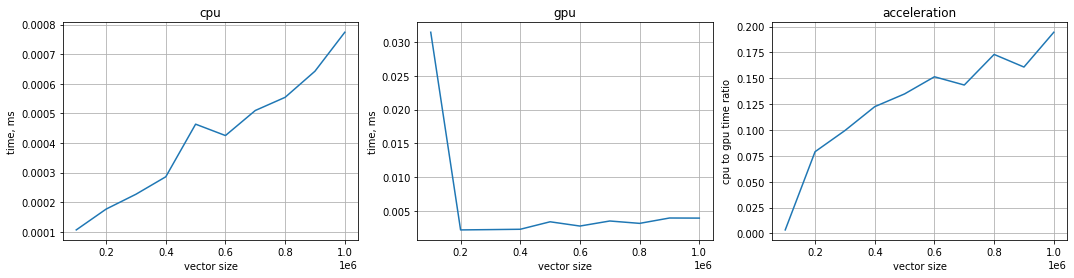

In [10]:
main()

In [11]:
def main2():
    rows = [] 
    vec_size_min = 100_000 
    vec_size_max = 1_000_000
    vec_size_interval = 100_000
    for vec_size in range(vec_size_min, vec_size_max + 1, vec_size_interval):
        correct_result = True
        cpu_time_sum = 0.
        gpu_time_sum = 0.
        for _ in range(ITER_COUNT):
            vec = np.random.randint(1000, size=vec_size)
            res = np.zeros(1, dtype=np.int32)

            d_vec = cuda.to_device(vec)
            d_res = cuda.to_device(res)
            start = time.time() 
            gpu_vec_sum[int((vec_size + TPB) / TPB), TPB](d_vec, d_res)
            gpu_time_sum += time.time() - start
            res = d_res.copy_to_host()

            start = time.time()
            real_res = np.sum(vec)
            cpu_time = time.time() - start
            cpu_time_sum += cpu_time

            correct_result = np.array_equal(res[0], real_res)
        row = [vec_size, correct_result, cpu_time_sum / ITER_COUNT, gpu_time_sum / ITER_COUNT]
        rows.append(row)
    print(tabulate(rows, headers=['vector size', 'result', 'cpu, ms', 'gpu, ms']))

    vec_sizes = list(map(lambda x: x[0], rows))
    cpu_times = list(map(lambda x: x[2], rows))
    gpu_times = list(map(lambda x: x[3], rows))
    accelerations = list(map(lambda x: x[2] / (x[3] if x[3] > EPS else EPS), rows))

    plt.figure(figsize=(18,4))

    plt.subplot(1, 3, 1)
    plt.title("cpu")
    plt.plot(vec_sizes, cpu_times)
    plt.xlabel("vector size")
    plt.ylabel("time, ms")
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("gpu")
    plt.plot(vec_sizes, gpu_times)
    plt.xlabel("vector size")
    plt.ylabel("time, ms")
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("acceleration")
    plt.plot(vec_sizes, accelerations)
    plt.xlabel("vector size")
    plt.ylabel("cpu to gpu time ratio")
    plt.grid()

    plt.show()

  vector size  result        cpu, ms      gpu, ms
-------------  --------  -----------  -----------
       100000  True      0.000108331  0.000405759
       200000  True      0.000166953  0.000285327
       300000  True      0.000240415  0.000310659
       400000  True      0.000310063  0.00028646
       500000  True      0.000373334  0.000270784
       600000  True      0.00050652   0.000404775
       700000  True      0.000525504  0.000330359
       800000  True      0.000571638  0.000286251
       900000  True      0.000641495  0.000309706
      1000000  True      0.000716597  0.000299752


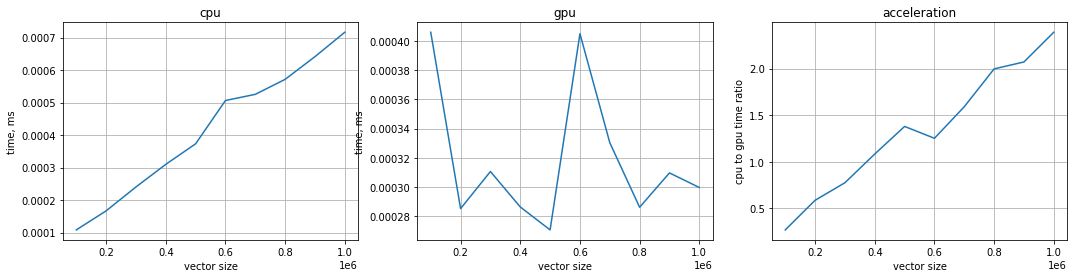

In [12]:
main2()